# Cardiac Arrhythmia Multi-Class Classification

Hello and welcome to my first Github machine learning project! Here we will be building some models to predict whether a person has some type of cardiac arrhythmia. The dataset has 452 records and 280 features, which means we do not have enough records to build a high-performance model. But this shouldn't stop us from building and tuning the best possible model for this dataset.  
  
From the dataset documentation we know that our label has several classes, some of which having zero instances in the dataset. This is not a problem, as we will assume that these classes do not exist.  
  
The following will be our strategy for this project:  
- Build simple classification models using KNN, Logistic Regression, SVM, Decision Trees, Random Forests. We will use GridSearch to tune each model's parameters, which also implements cross validation.
- Pick a set of parameters for each model that has low bias but high variance (aka overfitting, train score will be higher than test score). Perform bagging methods on these models. Then pick a set of parameters for each model that has high bias but low variance (in other words, train and test scores will be similar but the accuracy might be low). Perform boosting methods on them. The goal here is to see which method gives the best performance on each model.
- Use principal components analysis (PCA) to reduce the number of features while retaining as much information as possible, then build simple models to judge computation time and model performance.
- Choose the best model (simple, with bagging/boosting, or with PCA).

## Data Import

### Import major libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Read and inspect the data

In [3]:
cardiac = pd.read_csv('cardiac_arrhythmia.csv', header=None)

In [4]:
cardiac.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [5]:
print('Rows and columns of the dataset:', cardiac.shape)

Rows and columns of the dataset: (452, 280)


## Missing data

### Replace '?' with NaN's

In [6]:
cardiac.replace('?', np.nan, inplace=True)

### Check which columns have missing data

In [7]:
nulls = cardiac.isnull().sum().reset_index()
nulls.columns = ['Column', 'Number of Nulls']
nulls = nulls.loc[nulls['Number of Nulls'] != 0]
nulls

,Column,Number of Nulls
10,10,8
11,11,22
12,12,1
13,13,376
14,14,1


### Dealing with missing data

We can see that 376 values are missing in column 13 (Vector angles in degrees on front plane of QRST), which is 83% of the data. This column will have to be dropped since it has too many missing values.

In [8]:
cardiac.drop(columns=13, inplace=True)

For the rest of the columns, replace missing values with mean of that column:

In [9]:
for i in [10,11,12,14]:
    cardiac[i].fillna(cardiac[i].astype(float).mean(),inplace=True)

In [10]:
cardiac.corr()[cardiac.shape[1]].sort_values().head(257)

162   -0.197555
242   -0.189458
1     -0.178080
168   -0.171763
270   -0.164321
260   -0.162153
247   -0.159612
172   -0.158536
252   -0.150610
202   -0.142731
161   -0.135180
208   -0.134657
8     -0.122003
89    -0.118168
237   -0.108902
165   -0.105922
167   -0.102059
5     -0.099954
212   -0.099329
238   -0.094543
234   -0.093912
214   -0.093510
230   -0.092791
0     -0.092381
3     -0.090151
255   -0.086873
275   -0.086427
206   -0.084941
48    -0.084021
257   -0.083396
         ...   
229    0.119809
88     0.120726
107    0.121711
193    0.122928
249    0.124823
198    0.125873
65     0.127210
228    0.128490
149    0.130056
181    0.130360
119    0.132195
113    0.140502
56     0.141103
221    0.141274
152    0.141506
77     0.143284
239    0.151782
68     0.152534
191    0.165693
125    0.170670
52     0.173243
94     0.174346
29     0.183083
17     0.195198
233    0.218811
223    0.235488
102    0.282523
92     0.313982
4      0.323879
90     0.368876
Name: 279, Length: 257, 

Above are the columns with the most positive and negative correlations with our target variable. We can see that no strong correlations exist between the target variable and any other column in the data. This means that we should not expect a large accuracy even with the best model.

## Explore distribution of the target variable (column 279)

Text(0.5,0,'Arrhythmia')

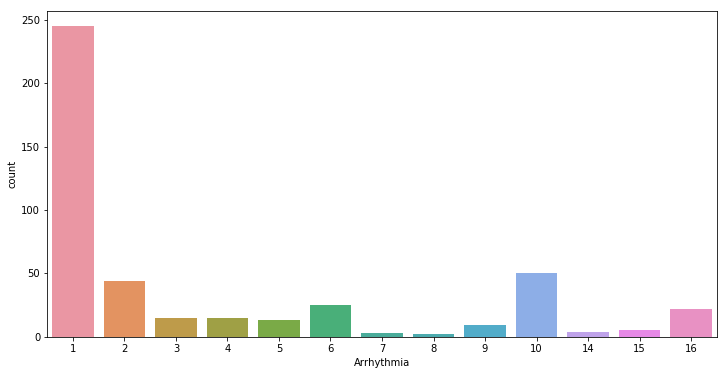

In [401]:
plt.figure(figsize=(12,6))
sns.countplot(x=279, data = cardiac)
plt.xlabel('Arrhythmia')

We can see that approximately half of the samples belong to the 'Normal' class. This imbalance will bias the results of any learning model. Therefore, bagging and boosting methods are required to make the most reliable predictions.

# Machine Learning Models

## Initial preprocessing

### Split data

In [29]:
X = cardiac.iloc[:, 0:278]
y = cardiac.iloc[:, 278]

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Scale data

In [31]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Simple classification models 

### K-Nearest Neighbors

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

kFold = StratifiedKFold(n_splits=8)

knn = KNeighborsClassifier(n_jobs=-1)
params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}

knn_grid = GridSearchCV(estimator=knn, param_grid=params, n_jobs=-1, cv=kFold)
knn_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
knn_grid_results = pd.DataFrame(knn_grid.cv_results_).sort_values('rank_test_score')
knn_grid_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.000000,0.117873,0.588608,0.625246,5,{'n_neighbors': 5},1,0.533333,0.634686,0.560976,...,0.631579,0.622302,0.578947,0.629496,0.657143,0.622776,0.000000,0.003191,0.037901,0.005459
1,0.003902,0.121129,0.582278,0.692148,2,{'n_neighbors': 2},2,0.511111,0.682657,0.560976,...,0.631579,0.712230,0.500000,0.694245,0.685714,0.669039,0.006758,0.008464,0.062175,0.011987
3,0.000000,0.115134,0.582278,0.639724,4,{'n_neighbors': 4},2,0.533333,0.649446,0.512195,...,0.605263,0.633094,0.578947,0.643885,0.657143,0.629893,0.000000,0.007681,0.044917,0.007451
5,0.000000,0.117177,0.582278,0.603534,6,{'n_neighbors': 6},2,0.533333,0.608856,0.512195,...,0.631579,0.607914,0.605263,0.600719,0.628571,0.601423,0.000000,0.007804,0.041638,0.003681
6,0.000000,0.114105,0.582278,0.599937,7,{'n_neighbors': 7},2,0.511111,0.605166,0.536585,...,0.631579,0.589928,0.605263,0.593525,0.657143,0.601423,0.000000,0.006641,0.045802,0.006345


We can see that 3 neighbors are the best parameters for this learning model using the elbow method below. However, this model overfits fits the data because of the difference in train and test core. Also, the train and test scores are still unacceptable. The 2nd ranking model (k = 6) would probably be the better choice. <br>The code below plots the error rate for every value of k between 1 and 10.

Text(0,0.5,'Error Rate')

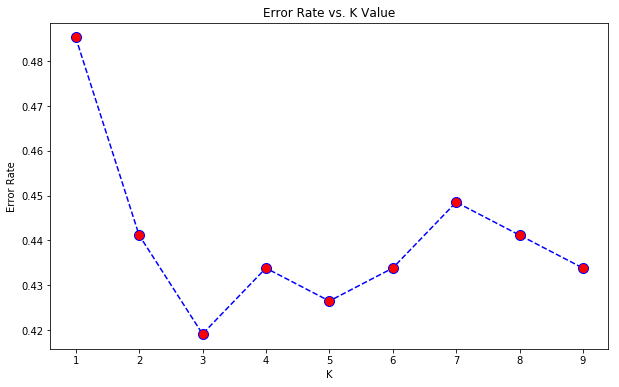

In [96]:
error_rate = []

for i in range(1,10):
    
    knn2 = KNeighborsClassifier(n_neighbors=i)
    knn2.fit(X_train,y_train)
    pred_i = knn2.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

### Logistic Regression

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(multi_class='multinomial', solver='lbfgs')
params = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100]}

LR_grid = GridSearchCV(estimator=LR, param_grid=params, cv=kFold)
LR_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
LR_grid_results = pd.DataFrame(LR_grid.cv_results_).sort_values('rank_test_score')
LR_grid_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.088138,0.000250,0.702532,0.850367,1,{'C': 1},1,0.688889,0.856089,0.682927,...,0.710526,0.856115,0.684211,0.838129,0.885714,0.850534,0.011317,0.000433,0.067706,0.008248
6,0.083177,0.000000,0.686709,0.967442,10,{'C': 10},2,0.666667,0.963100,0.682927,...,0.631579,0.964029,0.684211,0.971223,0.828571,0.971530,0.015225,0.000000,0.054737,0.006029
7,0.084620,0.000000,0.674051,0.999550,100,{'C': 100},3,0.688889,1.000000,0.609756,...,0.605263,1.000000,0.657895,1.000000,0.800000,1.000000,0.010446,0.000000,0.060608,0.001190
4,0.080079,0.000000,0.604430,0.645156,0.1,{'C': 0.1},4,0.533333,0.649446,0.560976,...,0.631579,0.643885,0.605263,0.640288,0.714286,0.637011,0.005167,0.000000,0.050284,0.005168
0,0.079257,0.001953,0.556962,0.557019,1e-05,{'C': 1e-05},5,0.488889,0.568266,0.536585,...,0.578947,0.553957,0.578947,0.553957,0.628571,0.548043,0.006575,0.005168,0.038937,0.005633


The mean train score is good, but the 20% difference between mean test and train scores implies that the model is overfitting. We select the model with the highest possible test score, with the smallest possible variance between test and train scores. This corresponds to C = 0.1

### Linear Support Vector Machine Classifier

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

LSVC = LinearSVC(multi_class='crammer_singer')

params = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100]}
LSVC_grid = GridSearchCV(estimator=LSVC, param_grid=params, n_jobs=-1, cv=kFold)
LSVC_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
LSVC_grid_results = pd.DataFrame(LSVC_grid.cv_results_).sort_values('rank_test_score')
LSVC_grid_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,1.976402,0.003906,0.721519,0.936706,1,{'C': 1},1,0.733333,0.940959,0.731707,...,0.657895,0.938849,0.605263,0.938849,0.885714,0.939502,0.432839,0.006766,0.074758,0.004063
4,0.650399,0.000000,0.712025,0.808737,0.1,{'C': 0.1},2,0.644444,0.804428,0.682927,...,0.710526,0.812950,0.710526,0.812950,0.828571,0.814947,0.135079,0.000000,0.052037,0.004847
7,4.369981,0.001953,0.639241,1.000000,100,{'C': 100},3,0.622222,1.000000,0.609756,...,0.684211,1.000000,0.605263,1.000000,0.685714,1.000000,0.350442,0.005168,0.034998,0.000000
6,4.594407,0.000751,0.636076,1.000000,10,{'C': 10},4,0.622222,1.000000,0.658537,...,0.684211,1.000000,0.578947,1.000000,0.685714,1.000000,0.755496,0.000434,0.034705,0.000000
3,0.248050,0.013672,0.575949,0.598111,0.01,{'C': 0.01},5,0.511111,0.601476,0.536585,...,0.578947,0.600719,0.605263,0.582734,0.628571,0.597865,0.063680,0.009367,0.040152,0.006782


Model has some bias and variance due to difference between mean train and test scores. This model overfits. We select the model with the highest possible test score, with the smallest possible variance between test and train scores. This corresponds to C = 0.01

### Kernelized Support Vector Machine 

In [32]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

SVC = SVC()
OVO_SVC = OneVsOneClassifier(estimator=SVC)

params = {'estimator__C': [0.0001,0.001,0.01,0.1,1,10,100],
          'estimator__gamma': [0.00001,0.0001,0.001,0.01,0.1,1,10,100],
          'estimator__kernel': ['poly']}
SVC_grid = GridSearchCV(estimator=OVO_SVC, param_grid=params, cv=kFold)
SVC_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=OneVsOneClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimator__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'estimator__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'estimator__kernel': ['poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
SVC_grid_results = pd.DataFrame(SVC_grid.cv_results_).sort_values('rank_test_score')
SVC_grid_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_estimator__C,param_estimator__gamma,param_estimator__kernel,params,rank_test_score,split0_test_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
51,0.072267,0.031251,0.718354,0.905972,100,0.01,poly,"{'estimator__C': 100, 'estimator__gamma': 0.01...",1,0.711111,...,0.684211,0.902878,0.657895,0.910072,0.857143,0.900356,0.007564,6.502099e-07,0.053006,0.003325
5,0.072267,0.031248,0.718354,0.905972,0.0001,1,poly,"{'estimator__C': 0.0001, 'estimator__gamma': 1...",1,0.711111,...,0.684211,0.902878,0.657895,0.910072,0.857143,0.900356,0.010875,5.033594e-06,0.053006,0.003325
28,0.071247,0.029295,0.718354,0.905972,0.1,0.1,poly,"{'estimator__C': 0.1, 'estimator__gamma': 0.1,...",1,0.711111,...,0.684211,0.902878,0.657895,0.910072,0.857143,0.900356,0.011687,5.173769e-03,0.053006,0.003325
55,0.070314,0.031251,0.680380,1.000000,100,100,poly,"{'estimator__C': 100, 'estimator__gamma': 100,...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.007813,4.906081e-07,0.056433,0.000000
23,0.070311,0.031251,0.680380,1.000000,0.01,100,poly,"{'estimator__C': 0.01, 'estimator__gamma': 100...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.007815,4.607327e-07,0.056433,0.000000
22,0.070314,0.029297,0.680380,1.000000,0.01,10,poly,"{'estimator__C': 0.01, 'estimator__gamma': 10,...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.007808,5.167483e-03,0.056433,0.000000
21,0.070313,0.031249,0.680380,1.000000,0.01,1,poly,"{'estimator__C': 0.01, 'estimator__gamma': 1, ...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.007813,5.230881e-06,0.056433,0.000000
54,0.076173,0.033204,0.680380,1.000000,100,10,poly,"{'estimator__C': 100, 'estimator__gamma': 10, ...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.014485,5.167934e-03,0.056433,0.000000
29,0.072793,0.031251,0.680380,1.000000,0.1,1,poly,"{'estimator__C': 0.1, 'estimator__gamma': 1, '...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.006992,8.311162e-06,0.056433,0.000000
36,0.066409,0.029297,0.680380,1.000000,1,0.1,poly,"{'estimator__C': 1, 'estimator__gamma': 0.1, '...",4,0.688889,...,0.605263,1.000000,0.631579,1.000000,0.800000,1.000000,0.010334,5.167393e-03,0.056433,0.000000


The best model for this Grid Search still overfits the training data. There is a 25% difference in mean train and test scores. As we did for LSVC, we will choose the model with the lowest variance: C = 10, gamma = 0.0001.

### Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DTF = DecisionTreeClassifier()

params = {'min_samples_leaf': [1,5,10,20,30,40,50],
          'min_samples_split': [2,3,4,5]}

DTF_grid = GridSearchCV(estimator=DTF, param_grid=params, cv=kFold, n_jobs=-1)
DTF_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50], 'min_samples_split': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
DTF_grid_results = pd.DataFrame(DTF_grid.cv_results_).sort_values('rank_test_score')
DTF_grid_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
10,0.025391,0.000000,0.680380,0.755445,10,4,"{'min_samples_leaf': 10, 'min_samples_split': 4}",1,0.622222,0.756458,...,0.736842,0.766187,0.657895,0.744604,0.685714,0.743772,0.010875,0.000000,0.050914,0.007831
9,0.021485,0.000000,0.677215,0.755445,10,3,"{'min_samples_leaf': 10, 'min_samples_split': 3}",2,0.622222,0.756458,...,0.710526,0.766187,0.657895,0.744604,0.685714,0.743772,0.007565,0.000000,0.048043,0.007831
8,0.023438,0.000000,0.677215,0.755445,10,2,"{'min_samples_leaf': 10, 'min_samples_split': 2}",2,0.622222,0.756458,...,0.710526,0.766187,0.657895,0.744604,0.685714,0.743772,0.007813,0.000000,0.048043,0.007831
11,0.019531,0.000000,0.677215,0.755445,10,5,"{'min_samples_leaf': 10, 'min_samples_split': 5}",2,0.622222,0.756458,...,0.710526,0.766187,0.657895,0.744604,0.685714,0.743772,0.006766,0.000000,0.048043,0.007831
6,0.027344,0.000000,0.639241,0.830081,5,4,"{'min_samples_leaf': 5, 'min_samples_split': 4}",5,0.666667,0.822878,...,0.552632,0.848921,0.684211,0.802158,0.571429,0.804270,0.006766,0.000000,0.068697,0.018033
4,0.027344,0.000000,0.626582,0.830081,5,2,"{'min_samples_leaf': 5, 'min_samples_split': 2}",6,0.666667,0.822878,...,0.526316,0.848921,0.684211,0.802158,0.571429,0.804270,0.006766,0.000000,0.063667,0.018033
5,0.029297,0.000000,0.626582,0.830081,5,3,"{'min_samples_leaf': 5, 'min_samples_split': 3}",6,0.666667,0.822878,...,0.578947,0.848921,0.605263,0.802158,0.571429,0.804270,0.005168,0.000000,0.065216,0.018033
7,0.023438,0.001953,0.613924,0.830081,5,5,"{'min_samples_leaf': 5, 'min_samples_split': 5}",8,0.644444,0.822878,...,0.552632,0.848921,0.578947,0.802158,0.571429,0.804270,0.007813,0.005167,0.064241,0.018033
15,0.015625,0.000000,0.610759,0.679045,20,5,"{'min_samples_leaf': 20, 'min_samples_split': 5}",9,0.577778,0.686347,...,0.631579,0.676259,0.552632,0.676259,0.628571,0.683274,0.000002,0.000000,0.041527,0.009492
12,0.015625,0.000000,0.610759,0.679045,20,2,"{'min_samples_leaf': 20, 'min_samples_split': 2}",9,0.577778,0.686347,...,0.631579,0.676259,0.552632,0.676259,0.628571,0.683274,0.000002,0.000000,0.041527,0.009492


The best possible model also has high bias and high variance.

### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(n_estimators=300, criterion='gini')

params = {'max_features': [80,100,140,200],
          'max_depth': [1,2,3,4,5]}

RF_grid = GridSearchCV(estimator=RF, param_grid=params, cv=kFold, n_jobs=-1)
RF_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [80, 100, 140, 200], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
RF_grid_results = pd.DataFrame(RF_grid.cv_results_).sort_values('rank_test_score')
RF_grid_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
18,2.117340,0.023438,0.724684,0.879783,5,140,"{'max_depth': 5, 'max_features': 140}",1,0.622222,0.885609,...,0.763158,0.888489,0.736842,0.888489,0.742857,0.861210,0.023306,7.812649e-03,0.051846,0.009074
19,2.660532,0.020869,0.715190,0.882030,5,200,"{'max_depth': 5, 'max_features': 200}",2,0.622222,0.881919,...,0.763158,0.895683,0.710526,0.892086,0.714286,0.861210,0.096080,8.169024e-03,0.054028,0.009936
17,1.681319,0.026269,0.712025,0.877517,5,100,"{'max_depth': 5, 'max_features': 100}",3,0.622222,0.885609,...,0.736842,0.881295,0.763158,0.888489,0.742857,0.857651,0.018037,1.640723e-03,0.050408,0.011037
16,1.452136,0.026894,0.699367,0.866659,5,80,"{'max_depth': 5, 'max_features': 80}",4,0.622222,0.885609,...,0.736842,0.870504,0.710526,0.877698,0.771429,0.868327,0.016615,1.764467e-03,0.049470,0.010178
15,2.370657,0.026923,0.696203,0.839099,4,200,"{'max_depth': 4, 'max_features': 200}",5,0.622222,0.845018,...,0.736842,0.838129,0.684211,0.845324,0.685714,0.822064,0.030648,2.146300e-03,0.050521,0.009238
13,1.451689,0.031251,0.686709,0.811532,4,100,"{'max_depth': 4, 'max_features': 100}",6,0.600000,0.822878,...,0.710526,0.805755,0.684211,0.802158,0.742857,0.797153,0.012009,5.646734e-07,0.054520,0.011204
12,1.254140,0.026644,0.686709,0.803871,4,80,"{'max_depth': 4, 'max_features': 80}",6,0.600000,0.815498,...,0.684211,0.791367,0.710526,0.802158,0.685714,0.786477,0.024674,1.495908e-03,0.044249,0.010156
14,1.826196,0.023438,0.683544,0.828238,4,140,"{'max_depth': 4, 'max_features': 140}",8,0.622222,0.837638,...,0.684211,0.827338,0.710526,0.830935,0.714286,0.818505,0.019822,7.812470e-03,0.034975,0.007916
10,1.423636,0.025018,0.664557,0.741471,3,140,"{'max_depth': 3, 'max_features': 140}",9,0.600000,0.752768,...,0.684211,0.733813,0.684211,0.741007,0.685714,0.729537,0.016534,1.659558e-03,0.046850,0.008945
9,1.198917,0.024892,0.664557,0.733306,3,100,"{'max_depth': 3, 'max_features': 100}",9,0.600000,0.738007,...,0.684211,0.741007,0.657895,0.744604,0.685714,0.711744,0.013665,1.054116e-03,0.047948,0.011226


This model is overfitting due to the large difference in mean train and test scores. The best model is {'max_depth': 2, 'max_features': 140}	

### Voting Classifier with LinearSVC, Random Forest, and KNN

In [75]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vote_clf = VotingClassifier(estimators=[('LinearSVC', LinearSVC(multi_class='crammer_singer', C=0.01)), 
                                        ('RandomF', RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=2, max_features=200)),
                                        ('KNN', KNeighborsClassifier(n_neighbors=5))])

accuracies = cross_val_score(estimator=vote_clf,X=X_train,y=y_train, scoring='accuracy', cv=kFold)

In [81]:
vote_clf.fit(X_train, y_train)

print('Mean Accuracy: {}'.format(accuracies.mean()))
print('Std.Dev of Accuracy: {}'.format(accuracies.std()))
print('Test set Accuracy: {}'.format(vote_clf.score(X_test, y_test)))

Mean Accuracy: 0.5719251762536423
Std.Dev of Accuracy: 0.03445185327570653
Test set Accuracy: 0.5661764705882353


## Machine Learning Models with Bagging and/or Boosting

Since the data is highly dimensional (has many features) and contains only a few observations, we need to use bootstrap aggregating (aka bagging). This means random subsets of the observations and features are drawn with replacement, and a model is trained on each subset. Sklearn's BaggingClassifier function will do the job seamlessly, then will use an aggregate function to make the most reliable predicitons. This method will reduce the variance of the predictions, which are not only due to the high dimensionality and small number of observations, but also due to the large imbalance in the target classes. However, bagging does NOT reduce the bias of the models; we do not expect to see an improvement in accuracy. This is where boosting comes in; the models are trained sequentially, taking into account underfitted datapoints for the next model. For the bagging models, we will use the hyperparameters that lead to high variance and low bias. As for the boosting models, we will use the hyperparameters that lead to low variance and high bias.

### Use all records for bagging/boosting

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaleX = MinMaxScaler()

X_scaled = scaleX.fit_transform(X)

### K-Nearest Neighbors with Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
bag_knn = BaggingClassifier(base_estimator=knn, n_estimators=300,bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=bag_knn, X=X_scaled, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [84]:
print('Mean accuracy:', accuracies.mean())
print('Std.Dev of accuracy:', accuracies.std())

Mean accuracy: 0.549040394251
Std.Dev of accuracy: 0.0348924265577


### K-Nearest Neighbors with Pasting

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

kFold = StratifiedKFold(n_splits = 8)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
paste_knn = BaggingClassifier(base_estimator=knn, bootstrap=False, n_estimators=300,bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=paste_knn, X=X_scaled, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [23]:
print('Mean accuracy:', accuracies.mean())
print('Std.Dev of accuracy:', accuracies.std())

Mean accuracy: 0.546991213923
Std.Dev of accuracy: 0.0367026058087


We can see that bagging/pasting reduced the variance but not that bias as expected. This is still not a good model, but at least it generalizes well. We will now use two boosting methods in order to lower the bias. KNeighborsClassifier does not support sample weights, so we will not be able to use Adaptive Boosting to lower the model bias.

### Logistic Regression with Bagging

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

kFold = StratifiedKFold(n_splits = 8)

LR = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
LR_bag = BaggingClassifier(base_estimator=LR, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=LR_bag, X=X_scaled, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [40]:
print('Mean accuracy:', accuracies.mean())
print('Std.Dev of accuracy:', accuracies.std())

Mean accuracy: 0.544587367769
Std.Dev of accuracy: 0.0339289227454


The bagging algorithm decreased the variance successfully, but raised the bias. Perhaps adaptive boosting could help raise it back to par.

### Logistic Regression with Pasting

In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

kFold = StratifiedKFold(n_splits = 8)

LR = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
LR_paste = BaggingClassifier(base_estimator=LR, n_estimators=300, bootstrap=False, bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=LR_paste, X=X_scaled, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [42]:
print('Mean accuracy:', accuracies.mean())
print('Std.Dev of accuracy:', accuracies.std())

Mean accuracy: 0.546991213923
Std.Dev of accuracy: 0.0367026058087


The pasting algorithm decreased the variance more than bagging, but raised the bias. Perhaps adaptive boosting could help raise it back to par.

### Logistic Regression with Adaptive Boosting

In [44]:
from sklearn.ensemble import AdaBoostClassifier

LR2 = LogisticRegression(C=0.1, multi_class='multinomial', solver='lbfgs')
LR_ada = AdaBoostClassifier(base_estimator=LR2, algorithm='SAMME',n_estimators=300, learning_rate=0.5)
LR_ada.fit(X_train, y_train)
print('Train Accuracy: ', LR_ada.score(X_train, y_train))
print('Test Accuracy: ', LR_ada.score(X_test, y_test))

Train Accuracy:  0.645569620253
Test Accuracy:  0.580882352941


We can see that adaptive boosting lowered the bias, but the variance is still high. A good approach would be to combine both bagging and boosting to logistic regression. However, this is not optimal seeing that the bias could still be improved.

### Linear Support Vector Machine Classifier with Bagging

In [96]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

LSVC = LinearSVC(C=1, multi_class='crammer_singer')
LSVC_bag = BaggingClassifier(base_estimator=LSVC, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=200)

In [97]:
accuracies = cross_val_score(estimator=LSVC_bag, X=X_scaled, y=y, scoring='accuracy', cv=5, n_jobs=-1)
print('Mean accuracy:', accuracies.mean())
print('Std.Dev of accuracy:', accuracies.std())

Mean accuracy: 0.715197261471
Std.Dev of accuracy: 0.0268268912503


We can see that the variance has been improved, however the bias is still high so will try adaptive boosting.

### Linear Support Vector Machine Classifier with Pasting

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

LSVC = LinearSVC(C=1, multi_class='crammer_singer')
LSVC_paste = BaggingClassifier(base_estimator=LSVC, n_estimators=300, bootstrap=False,bootstrap_features=True, max_samples=100, max_features=200)

In [48]:
accuracies = cross_val_score(estimator=LSVC_paste, X=X_scaled, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)
print('Mean accuracy:', accuracies.mean())
print('Std.Dev of accuracy:', accuracies.std())

Mean accuracy: 0.716971038621
Std.Dev of accuracy: 0.0513783713695


### Linear Support Vector Machine Classifier with Adaptive Boosting

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

LSVC2 = LinearSVC(C=0.01, multi_class='crammer_singer')

LSVC_ada = AdaBoostClassifier(base_estimator=LSVC2, algorithm='SAMME',n_estimators=300, learning_rate=0.5)
LSVC_ada.fit(X_train, y_train)
print('Train Accuracy: ', LSVC_ada.score(X_train, y_train))
print('Test Accuracy: ', LSVC_ada.score(X_test, y_test))

Train Accuracy:  0.613924050633
Test Accuracy:  0.551470588235


We can see that adaptive boosting did in fact raise the average accuracy for the LinearSVC. However, it will not work on its own; we need to do both bagging and boosting for this model.

### Support Vector Machine with Bagging

In [104]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

SVC = SVC(C=0.0001, gamma=1, kernel='poly')
SVC_OVR = OneVsRestClassifier(estimator=SVC)
SVC_bag = BaggingClassifier(base_estimator=SVC, n_estimators=100, bootstrap_features=True, max_samples=200, max_features=X.shape[1])

In [106]:
accuracies = cross_val_score(estimator=SVC_bag, X=X_scaled, y=y, scoring='accuracy', cv=5)
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.662822904146
Std.Dev of Accuracy:  0.0575169179181


### Support Vector Machine with Pasting

In [107]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

SVC = SVC(C=0.0001, gamma=1, kernel='poly')
SVC_OVR = OneVsRestClassifier(estimator=SVC)
SVC_bag = BaggingClassifier(base_estimator=SVC, n_estimators=100, bootstrap=False,bootstrap_features=True, max_samples=200, max_features=X.shape[1])

In [108]:
accuracies = cross_val_score(estimator=SVC_bag, X=X_scaled, y=y, scoring='accuracy', cv=5)
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.693487839795
Std.Dev of Accuracy:  0.0581710775429


We can see that the variance of the model has improved with bagging. We cannot apply adaptive boosting to increase the accuracy of the model since OneVsRestClassifier does not support sample weights.

### Decision Tree with Bagging

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

DTF = DecisionTreeClassifier(min_samples_leaf=10, min_impurity_split=3)
DTF_bag = BaggingClassifier(base_estimator=DTF, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=DTF_bag, X=X_scaled, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [53]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.542510843787
Std.Dev of Accuracy:  0.0162029371765


### Decision Tree with Pasting

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

DTF = DecisionTreeClassifier(min_samples_leaf=10, min_impurity_split=3)
DTF_paste = BaggingClassifier(base_estimator=DTF, n_estimators=300, bootstrap=False, bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=DTF_paste, X=X_scaled, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [56]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.542510843787
Std.Dev of Accuracy:  0.0162029371765


### Decision Tree Classifier with Adaptive Boosting

In [59]:
from sklearn.ensemble import AdaBoostClassifier

DTF2 = DecisionTreeClassifier(min_samples_leaf=50, min_impurity_decrease=2)
DTF_ada = AdaBoostClassifier(base_estimator=DTF2, algorithm='SAMME',n_estimators=300, learning_rate=0.5)
DTF_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=2, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=300, random_state=None)

In [60]:
print('Train Accuracy: ', DTF_ada.score(X_train, y_train))
print('Test Accuracy: ', DTF_ada.score(X_test, y_test))

Train Accuracy:  0.556962025316
Test Accuracy:  0.507352941176


### Random Forest with Bagging

In [66]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score

RF = RandomForestClassifier(n_estimators=300, max_features=140, max_depth=5)
RF_bag = BaggingClassifier(base_estimator=RF, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=RF_bag, X=X_scaled, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [67]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.626595060915
Std.Dev of Accuracy:  0.0334773080778


### Random Forest with Pasting

In [68]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score

RF2 = RandomForestClassifier(n_estimators=300, max_features=140, max_depth=2)
RF_bag = BaggingClassifier(base_estimator=RF2, n_estimators=300, bootstrap=False, bootstrap_features=True, max_samples=100, max_features=200)

accuracies = cross_val_score(estimator=RF_bag, X=X_scaled, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [69]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.585143035358
Std.Dev of Accuracy:  0.0378362319751


### Random Forest with Adaptive Boosting

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

RF = RandomForestClassifier(n_estimators=300, max_features=140, max_depth=2)
RF_ada = AdaBoostClassifier(base_estimator=RF, algorithm='SAMME.R',n_estimators=300, learning_rate=0.1)
RF_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=140, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=0.1, n_estimators=300, random_state=None)

In [62]:
print('Train Accuracy: ', RF_ada.score(X_train, y_train))
print('Test Accuracy: ', RF_ada.score(X_test, y_test))

Train Accuracy:  0.851265822785
Test Accuracy:  0.617647058824


We can see that the adaptive boosting only slightly imporved the test accuracy.

### Gradient Boosting

We will first use the baseline model and benchmark its mean accuracy and standard deviation after cross-validation. Then we can try to tune the hyperparameters to get a better score.

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

GB_baseline = GradientBoostingClassifier()

accuracies = cross_val_score(estimator=GB_baseline, X=X_scaled, y=y, cv=kFold, n_jobs=-1)
print('Mean Accuracy:', accuracies.mean())
print('Std.Dev of Accuracy:', accuracies.std())

Mean Accuracy: 0.726318918202
Std.Dev of Accuracy: 0.0259648678389


This is a good model, as compared to previous ones. Let's try to improve it further by tweaking the most significant parameters.

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

GB_baseline2 = GradientBoostingClassifier(min_samples_leaf=9, learning_rate=0.05, n_estimators=100)

accuracies = cross_val_score(estimator=GB_baseline2, X=X_scaled, y=y, cv=kFold, n_jobs=-1)
print('Mean Accuracy:', accuracies.mean())
print('Std.Dev of Accuracy:', accuracies.std())

Mean Accuracy: 0.762605140897
Std.Dev of Accuracy: 0.0364546994011


We can see that the gradient boosting algorithm has the best bias-variance tradeoff, achieving the lowest possible bias among all models, and an acceptable variance.

It is clear that, while the bagging and boosting techniques mentioned above are usually effective, most did not do much to improve the models. This is due to the three factors mentioned earlier:
<u1>
<li>Imbalance in target classes.</li>
<li>High dimensionality of the data.</li>
<li>Scarcity of observations.</li>
</u1>
<br>We will now perform principal components analysis (PCA) to reduce the dimensionality of our dataset, then apply the same algorithms. We expect to see better results in terms of bias and variance with this approach. It may not improve the simple implementation of our machine learning algorithms due to information loss, but it will allow for computationally expensive approaches (such as combining bagging and boosting together) that would take a long time to execute without PCA.


## Machine Learning Models with Principal Component Analysis (PCA)

### Find optimal number of dimensions

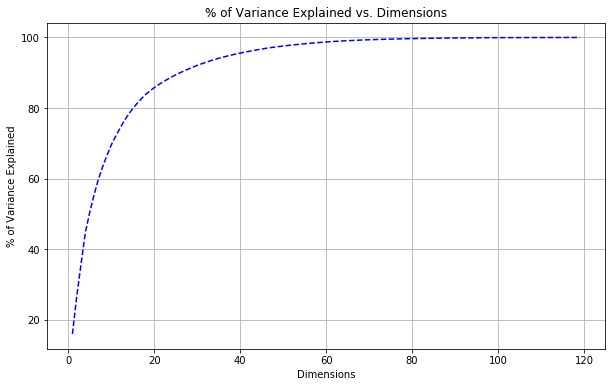

In [91]:
from sklearn.decomposition import PCA

var_exp = []

for i in range(1,120):
    pca = PCA(n_components=i, svd_solver='auto')
    X_pca = pca.fit_transform(X)
    var_exp.append(pca.explained_variance_ratio_.sum())
    
var_exp_perc = [i*100 for i in var_exp]
    
plt.figure(figsize=(10,6))
plt.plot(range(1,120),var_exp_perc,color='blue', linestyle='dashed')
plt.title('% of Variance Explained vs. Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('% of Variance Explained')
plt.grid(True)

We can see that 100 dimensions is a good choice, as ~100% of the variance is explained with this number of dimensions

### Split and Scale data

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Apply PCA

In [93]:
pca = PCA(n_components=100, svd_solver='auto')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_comb_pca = np.concatenate((X_train_pca, X_test_pca), axis=0)

### K-Nearest Neighbor Classifier with Bagging

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

kFold = StratifiedKFold(n_splits=8)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
bag_knn_pca = BaggingClassifier(base_estimator=knn, n_estimators=300,bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=bag_knn_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [18]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.544587367769
Std.Dev of Accuracy:  0.0339289227454


### K-Nearest Neighbor Classifier with Pasting

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
paste_knn_pca = BaggingClassifier(base_estimator=knn, n_estimators=300, bootstrap=False,bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=paste_knn_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [20]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.544587367769
Std.Dev of Accuracy:  0.0339289227454


### Logistic Regression with Bagging

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

LR = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
LR_bag_pca = BaggingClassifier(base_estimator=LR, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=LR_bag_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [22]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.544587367769
Std.Dev of Accuracy:  0.0339289227454


### Logistic Regression with Pasting

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

LR = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
LR_paste_pca = BaggingClassifier(base_estimator=LR, n_estimators=300, bootstrap=False,bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=LR_paste_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=kFold, n_jobs=-1)

In [25]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.544587367769
Std.Dev of Accuracy:  0.0339289227454


### Logistic Regression with Adaptive Boosting

In [28]:
from sklearn.ensemble import AdaBoostClassifier
LR_ada = AdaBoostClassifier(base_estimator=LR, algorithm='SAMME',n_estimators=300, learning_rate=0.5)
LR_ada.fit(X_train_pca, y_train)
print('Train Accuracy: ', LR_ada.score(X_train_pca, y_train))
print('Test Accuracy: ', LR_ada.score(X_test_pca, y_test))

Train Accuracy:  0.768987341772
Test Accuracy:  0.595588235294


We can see that adaptive boosting did in fact raise the test accuracy, but the model still has high variance.

### Linear Support Vector Machine Classifier with Bagging

In [51]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

LSVC = LinearSVC(C=0.01, multi_class='crammer_singer')
LSVC_bag_pca = BaggingClassifier(base_estimator=LSVC, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=LSVC_bag_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [53]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.5293197821
Std.Dev of Accuracy:  0.0218244262426


### Linear Support Vector Machine Classifier with Pasting

In [54]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

LSVC = LinearSVC(C=0.01, multi_class='crammer_singer')
LSVC_paste_pca = BaggingClassifier(base_estimator=LSVC, n_estimators=300, bootstrap=False, bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=LSVC_paste_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [55]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.526994200705
Std.Dev of Accuracy:  0.0176014273875


### Linear Support Vector Machine with Adaptive Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

LSVC = LinearSVC(C=0.01, multi_class='crammer_singer')

LR_ada = AdaBoostClassifier(base_estimator=LR, algorithm='SAMME',n_estimators=300, learning_rate=0.5)
LR_ada.fit(X_train_pca, y_train)
print('Train Accuracy: ', LR_ada.score(X_train_pca, y_train))
print('Test Accuracy: ', LR_ada.score(X_test_pca, y_test))

### Kernelized Support Vector Machine with Bagging

In [58]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

SVC = SVC(C=0.0001, gamma=1, kernel='poly')
SVC_OVR = OneVsRestClassifier(estimator=SVC)
SVC_bag_pca = BaggingClassifier(base_estimator=SVC_OVR, n_estimators=100, bootstrap_features=True, max_samples=200, max_features=60)

accuracies = cross_val_score(estimator=SVC_bag_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [60]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.542510843787
Std.Dev of Accuracy:  0.0162029371765


### Kernelized Support Vector Machine with Pasting

In [61]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

SVC = SVC(C=0.0001, gamma=1, kernel='poly')
SVC_OVR = OneVsRestClassifier(estimator=SVC)
SVC_paste_pca = BaggingClassifier(base_estimator=SVC_OVR, n_estimators=100, bootstrap=False,bootstrap_features=True, max_samples=200, max_features=60)

accuracies = cross_val_score(estimator=SVC_paste_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [62]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.542510843787
Std.Dev of Accuracy:  0.0162029371765


### Decision Tree with Bagging

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

DTF = DecisionTreeClassifier(min_samples_leaf=10, min_impurity_split=5)
DTF_bag_pca = BaggingClassifier(base_estimator=DTF, n_estimators=300, bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=DTF_bag_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [71]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.542510843787
Std.Dev of Accuracy:  0.0162029371765


### Decision Tree with Pasting

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

DTF = DecisionTreeClassifier(min_samples_leaf=10, min_impurity_split=5)
DTF_paste_pca = BaggingClassifier(base_estimator=DTF, n_estimators=300, bootstrap=False,bootstrap_features=True, max_samples=100, max_features=60)

accuracies = cross_val_score(estimator=DTF_paste_pca, X=X_comb_pca, y=y, scoring='accuracy', cv=5, n_jobs=-1)

In [74]:
print('Mean Accuracy: ', accuracies.mean())
print('Std.Dev of Accuracy: ', accuracies.std())

Mean Accuracy:  0.542510843787
Std.Dev of Accuracy:  0.0162029371765


### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(n_estimators=300)

params = {'max_features': [18,22,25,30],
          'max_depth': [1,2,3]}

RF_grid = GridSearchCV(estimator=RF, param_grid=params, cv=5, n_jobs=-1)
RF_grid.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [18, 22, 25, 30], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
RF_grid_results = pd.DataFrame(RF_grid.cv_results_).sort_values('rank_test_score')
RF_grid_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
10,0.947860,0.025060,0.566456,0.634558,3,25,"{'max_depth': 3, 'max_features': 25}",1,0.536232,0.647773,...,0.546875,0.630952,0.583333,0.617188,0.637931,0.643411,0.016548,9.059691e-03,0.037816,0.010667
0,0.341688,0.012233,0.556962,0.557074,1,18,"{'max_depth': 1, 'max_features': 18}",2,0.521739,0.566802,...,0.546875,0.559524,0.583333,0.550781,0.603448,0.546512,0.008323,5.068366e-03,0.029843,0.007398
1,0.498662,0.027826,0.556962,0.557074,1,22,"{'max_depth': 1, 'max_features': 22}",2,0.521739,0.566802,...,0.546875,0.559524,0.583333,0.550781,0.603448,0.546512,0.135743,6.128038e-03,0.029843,0.007398
2,0.621883,0.031250,0.556962,0.557074,1,25,"{'max_depth': 1, 'max_features': 25}",2,0.521739,0.566802,...,0.546875,0.559524,0.583333,0.550781,0.603448,0.546512,0.006250,0.000000e+00,0.029843,0.007398
3,0.660290,0.028126,0.556962,0.557074,1,30,"{'max_depth': 1, 'max_features': 30}",2,0.521739,0.566802,...,0.546875,0.559524,0.583333,0.550781,0.603448,0.546512,0.006250,6.250191e-03,0.029843,0.007398
4,0.691178,0.031251,0.556962,0.560221,2,18,"{'max_depth': 2, 'max_features': 18}",2,0.521739,0.566802,...,0.546875,0.563492,0.583333,0.554688,0.603448,0.550388,0.006445,5.560829e-07,0.029843,0.006508
5,0.740634,0.031251,0.556962,0.563325,2,22,"{'max_depth': 2, 'max_features': 22}",2,0.521739,0.566802,...,0.546875,0.567460,0.583333,0.558594,0.603448,0.562016,0.012500,4.156970e-07,0.029843,0.003339
6,0.788646,0.028125,0.556962,0.565728,2,25,"{'max_depth': 2, 'max_features': 25}",2,0.521739,0.570850,...,0.546875,0.567460,0.583333,0.558594,0.603448,0.562016,0.007090,6.249881e-03,0.029843,0.004687
7,0.837789,0.028126,0.556962,0.566441,2,30,"{'max_depth': 2, 'max_features': 30}",2,0.521739,0.566802,...,0.546875,0.567460,0.583333,0.554688,0.603448,0.577519,0.005454,6.249690e-03,0.029843,0.007246
8,0.807162,0.028126,0.556962,0.626666,3,18,"{'max_depth': 3, 'max_features': 18}",2,0.521739,0.639676,...,0.546875,0.630952,0.583333,0.613281,0.603448,0.627907,0.007655,6.250143e-03,0.029843,0.008887


### Gradient Boosting

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

GB_baseline2 = GradientBoostingClassifier(min_samples_leaf=9, learning_rate=0.05, n_estimators=100)

accuracies = cross_val_score(estimator=GB_baseline2, X=X_comb_pca, y=y, cv=kFold, n_jobs=-1)
print('Mean Accuracy:', accuracies.mean())
print('Std.Dev of Accuracy:', accuracies.std())

Mean Accuracy: 0.524641336864
Std.Dev of Accuracy: 0.0393769421816


These models all perform poorly compared to the unreduced models in the previous section. This is largely due to scarcity of records.

## Choosing Best Model

We will do a final sanity check on our top two models (bagged LSVC and Gradient Boost). We will also check their classificaiton reports and confusion matrices to analyze the details of how well they performed.

In [98]:
LSVC_bag.fit(X_train, y_train)
print('Bagged LSVC Test Accuracy:', LSVC_bag.score(X_test, y_test))

Bagged LSVC Test Accuracy: 0.676470588235


In [99]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report for bagged LSVC:')
print(classification_report(y_true = y_test, y_pred= LSVC_bag.predict(X_test)))
print('\n')
print('Confusion Matrix for bagged LSVC:')
print(confusion_matrix(y_true = y_test, y_pred= LSVC_bag.predict(X_test)))

Classification Report for bagged LSVC:
             precision    recall  f1-score   support

          1       0.67      0.96      0.79        69
          2       0.56      0.45      0.50        11
          3       1.00      1.00      1.00         7
          4       0.33      0.33      0.33         3
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00        10
          8       0.00      0.00      0.00         1
          9       0.50      1.00      0.67         1
         10       0.75      0.63      0.69        19
         14       0.00      0.00      0.00         3
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.55      0.68      0.60       136



Confusion Matrix for bagged LSVC:
[[66  1  0  1  0  0  0  0  1  0  0  0]
 [ 6  5  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  1  0  0  0]
 [ 3  0  0  0  0  0  0  

In [100]:
GB_baseline2.fit(X_train, y_train)
print('GB Test Accuracy:', GB_baseline2.score(X_test, y_test))

GB Test Accuracy: 0.691176470588


In [101]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report for GB:')
print(classification_report(y_true = y_test, y_pred= GB_baseline2.predict(X_test)))
print('\n')
print('Confusion Matrix for GB:')
print(confusion_matrix(y_true = y_test, y_pred= GB_baseline2.predict(X_test)))

Classification Report for GB:
             precision    recall  f1-score   support

          1       0.70      0.94      0.80        69
          2       0.67      0.55      0.60        11
          3       1.00      0.29      0.44         7
          4       0.33      0.33      0.33         3
          5       0.75      0.75      0.75         4
          6       0.88      0.70      0.78        10
          8       0.00      0.00      0.00         1
          9       1.00      1.00      1.00         1
         10       0.75      0.47      0.58        19
         14       0.00      0.00      0.00         3
         15       0.00      0.00      0.00         1
         16       0.00      0.00      0.00         7

avg / total       0.67      0.69      0.65       136



Confusion Matrix for GB:
[[65  1  0  1  0  0  0  0  1  0  0  1]
 [ 4  6  0  0  0  1  0  0  0  0  0  0]
 [ 3  0  2  0  1  0  0  0  0  0  0  1]
 [ 1  0  0  1  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  3  0  0  0  0  0  0  0]
 [ 

## Conclusion

As mentioned before, the following are the reasons that the models did not perform well even with dimensionality reduction, bagging/boosting methods, and GridSearch:
- Scarcity of data: the dataset has too few records (452)
- High dimensionality: the dataset has too many features (280), none of which having a strong correlation with the target variable.
- Imbalance in target classes: The majority of records are of the 'Normal' class, which biases the dataset. Oversampling/undersampling methods would not work. Oversampling would create too many synthetic observations, which might cause the models to overfit. Undersampling will lead to too few records. This is why bagging was the best option to deal with this problem, which also did not help fix this issue.


The best model for this data would have to the Gradient Boosting, achieving an accuracy of 69.1% on the test set.